## KMEANS 分群

Populating the interactive namespace from numpy and matplotlib


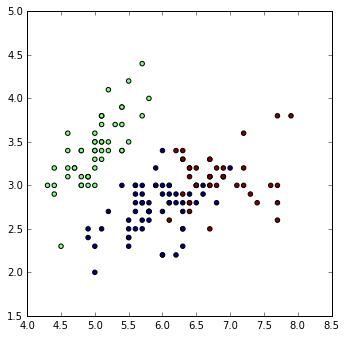

In [143]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from sklearn.datasets import load_iris
iris = load_iris()

X_iris = iris.data
y_iris = iris.target

k_means = cluster.KMeans(n_clusters=3)
y_pred = k_means.fit_predict(X_iris) 

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_iris[:,0], X_iris[:,1], c=y_pred)

plt.show()

## 讀取Page View

In [1]:
import pandas
pageview = pandas.read_hdf('pageview0720_0730.h5')

In [2]:
pageview.EventTimestamp.describe()

count                        8887227
unique                       8369985
top       2016-07-29 10:29:12.964000
freq                               7
first     2016-07-20 00:00:00.342000
last      2016-07-31 23:59:59.996000
Name: EventTimestamp, dtype: object

## 資料前處理

In [5]:
pageview.PageLocation = pageview.PageLocation.str.lower()

In [6]:
pageview.head()

,EventTimestamp,PageLocation,SessionNumber,TrackingUuid
0,2016-07-20 16:11:23.384,https://www.mybank.com.tw/mybank/home/mymobibank,20029488,e91778f6-dd1a-469a-ae6e-8778e71c3460
1,2016-07-20 20:12:59.788,https://www.mybank.com.tw/mybank/quicklinks/ho...,20105815,a9fdf990-bd01-4370-87ec-72f1cf0b257f
2,2016-07-20 11:31:30.485,https://www.mybank.com.tw/mybank/quicklinks/home,19880321,4170b9b6-6cd0-4452-a40f-0469fdbf4489
5,2016-07-20 12:17:57.815,https://www.cathaybk.com.tw/cathaybk/personal_...,19906076,2ca95944-8442-49cd-b37b-e18d460e003a
6,2016-07-20 09:49:22.541,https://www.mybank.com.tw/mybank/quicklinks/ho...,19815597,9984fbef-6750-4e57-87c7-656f0b361d65


## 讀取URL 對照表

In [8]:
import pandas
url_mapping_raw = pandas.read_excel('bigdata/url_mapping.xlsx', 
                    sheetname = [i for i in range(1,13)])
url_mapping_concat = pandas.concat(url_mapping_raw)
tag_map  = url_mapping_concat[['URL', '層級2','頁面名稱']]
tag_map['URL'] = tag_map['URL'].str.lower()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 合併tag 與 pageview 資料

In [10]:
# 有很多連結還沒有標計 (可用left 檢查)
visitor_pageview_tag = pandas.merge(pageview ,tag_map, left_on='PageLocation', right_on='URL', how = 'inner')

In [12]:
visitor_pageview_tag[['SessionNumber', '層級2']].head()

,SessionNumber,層級2
0,20029488,行動首頁
1,20094212,行動首頁
2,19750404,行動首頁
3,20031099,行動首頁
4,19896084,行動首頁


In [20]:
visitor_pageview_tag_grp = visitor_pageview_tag.groupby(['SessionNumber','層級2'])['層級2'].count()

In [24]:
visitor_pageview_tag_grp.name = 'count'

In [28]:
visitor_pageview_tag_grp = visitor_pageview_tag_grp.reset_index()

## 產生計算矩陣

In [64]:
visitor_pageview_tag_grp_df = visitor_pageview_tag_grp.pivot(index='SessionNumber', columns='層級2', values='count')

In [66]:
sample_df = visitor_pageview_tag_grp_df.iloc[0:10000,]

In [67]:
visitor_pageview_tag_mat = sample_df.as_matrix()

In [68]:
import numpy as np
visitor_pageview_tag_mat = np.nan_to_num(visitor_pageview_tag_mat)

In [70]:
print(visitor_pageview_tag_mat.shape)
visitor_pageview_tag_mat

(10000, 128)


array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  3.],
       [ 0.,  0.,  0., ...,  0.,  0.,  7.]])

## 計算行為相似度

In [74]:
from sklearn.metrics.pairwise import cosine_similarity
session_similarities = cosine_similarity(visitor_pageview_tag_mat, visitor_pageview_tag_mat)
#print(cosine_similarities)

In [75]:
session_similarities.shape

(10000, 10000)

## 使用者分群

In [121]:
from sklearn import cluster
num_clusters = 10
model = cluster.KMeans(n_clusters=num_clusters)
clustered_data = model.fit_predict(visitor_pageview_tag_mat)


In [122]:
cluster_size = np.sum(clustered_data == 3)
cluster_size

2326

In [131]:
for c in range(0,num_clusters):
    clustered_user =  sample_df[clustered_data == c].sum(numeric_only=True)
    
    print(c, clustered_user[clustered_user> (cluster_size * 0.1) ].sort_values(ascending=False))

0 層級2
行動銀行    4474.0
行動首頁    2064.0
dtype: float64
1 層級2
外匯業務    360.0
dtype: float64
2 層級2
首頁      3025.0
線上櫃台     368.0
登出       323.0
dtype: float64
3 層級2
首頁      4731.0
線上櫃台    2694.0
登出      1715.0
繳費服務     270.0
dtype: float64
4 層級2
企業用戶    290.0
dtype: float64
5 層級2
行動首頁            1392.0
線上櫃台            1248.0
信用卡新聞           1201.0
首頁               942.0
卡片介紹             316.0
刷卡優惠-信用卡活動登陸     305.0
dtype: float64
6 層級2
企業用戶    594.0
dtype: float64
7 層級2
刷卡優惠-舞動紅利    249.0
紅利兌換         240.0
dtype: float64
8 層級2
首頁    354.0
dtype: float64
9 層級2
外匯業務             1751.0
資訊看板-利率/匯率/淨值     925.0
dtype: float64


## 評估分群結果

In [128]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(visitor_pageview_tag_mat, clustered_data)

In [129]:
silhouette_avg

0.29641080705717671

In [130]:
model.predict(np.nan_to_num(visitor_pageview_tag_grp_df.iloc[20000:20010,].as_matrix()) )

array([5, 0, 3, 0, 5, 9, 6, 3, 9, 5])